In [1]:
%%html
<style>
table,td,tr,th {border:none!important}
</style>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import wavfile
from scipy import signal
from scipy.fftpack import fft
from scipy.signal import blackman
from math import exp, expm1,pi
from numpy import cos, sin, pi, absolute, arange
from scipy.signal import kaiserord, lfilter, firwin, freqz
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show
%matplotlib inline
#%matplotlib notebook

# <center> Introduction to Jupyter Notebooks and </center> <center> Ultrasonic Project Updates </center>
<center> Jarrod Zacher </center><center>Colorado State University, Fort Collins, CO </center><center>March 2017</center>
<table>
    <tr>
    <td> <img src="img/CSULogo.png" alt="Drawing" style="width: 175px;"/> </td>
    <td> <img src="img/NPSlogo.png" alt="Drawing" style="width: 100px;"/> </td>
    </tr>
</table>

## Motivation

<p style="font-size:17px"> Design a Low Power, Low Cost Ultrasonic Adapter for Commercial Audio Recorders  </p>

* COTS recorders cannot capture bat vocalizations due to the Nyquist sampling theorem (->aliasing)
* Landscape monitoring of bats
* White-nose syndrome , Wind Farms
* Existing units are too expensive for large scale deployment
<table >
    <tr>
    <td> <img src="img/UltrasoundRecord.png" alt="Drawing" style="width: 430px;"/> </td>
    <td> <img src="img/Whitenose.jpg" alt="Drawing" style="width: 310px;"/> </td>
    </tr>
</table>

## Method

Key Ideas:
* Shift a signal spectrum from one center frequency to another
* Multiply bat vocalizations by a complex exponential to shift the spectrum

Euler identities :<br>
$ e^{\ jx} = cos(x) + j\cdot sin(x)$ <br>
$sin(x) = \frac{e^{\ jx}-e^{-jx}}{2j}$ <br>
$cos(x) = \frac{e^{\ jx}+e^{-jx}}{2}$ <br> <br>
Fourier transform frequency shifting property:<br>
if $x(t) \Longleftrightarrow X(\omega) $ then,<br>
$x(t)\cdot e^{\ j\omega_o t} \Longleftrightarrow X(\omega - \omega_o) $ <br>
$x(t)\cdot cos(\omega_o t) \Longleftrightarrow \frac{1}{2}[ X(\omega - \omega_o) + X(\omega + \omega_o)] $ <br> <br>
$x(t)= $ bat vocalization signal <br>
$\omega_c=2\pi f_c$ , where $f_c$ is the center frequency <br>
<center> $\bf{Modulate\ x(t)}$</center>
$$
x(t)e^{-j\omega_c t} =x(t)\cdot cos(\omega_c t) - x(t)\cdot j\cdot sin(\omega_c t)
$$
<center>$\bf{Split\ into\ two\ channels}$ <br>
Channel 1 : $x(t)\frac{1}{2} (e^{\ j\omega_c t} + e^{-j\omega_c t}) \Longleftrightarrow \frac{1}{2}[ X(\omega - \omega_c) + X(\omega + \omega_c)] $<br>
Channel 2 : $-x(t)\frac{1}{2} (e^{\ j\omega_c t} - e^{-j\omega_c t}) \Longleftrightarrow - \frac{1}{2}[ X(\omega - \omega_c) - X(\omega + \omega_c)] $<br> 
$\bf{Filter\ out\ higher\ frequency\ shifts}$ <br>
Channel 1 : $\frac{1}{2}[ X(\omega - \omega_c)] $<br>
Channel 2 : $-\frac{1}{2}[ X(\omega - \omega_c)] $<br> 
$\bf{.}$<br> 
$\bf{.}$<br> 
$\bf{.}$<br> 
</center>

<center> $\bf{Combine channels\ x(t)}$</center> <br>
<center> $\bf{demodulate\ x(t)}$</center> <br>

<center>$\bf{Filter\ out\ lower?\ frequency\ shifts}$ </center><br>

Multiplying $x(t)$ by a complex exponential shifts the spectrum of $x(t)$ by $\omega_o$. Implementing frequency shifting on embedded systems is achieved by multiplying $x(t)$ by a sinusoid. However, this produces replicas in the frequency domain at positive and negative frequencies. The undesirable replica must be filtered out. 

## Algorithm Test

In [3]:
FS_acquire = 960000
T_acquire = 1/FS_acquire;  

numSamples = 3/T_acquire;
t = np.linspace(0, numSamples * T_acquire, numSamples)             
testFreq=33000;
deltaFreq=48000;
#temp=1j*2*pi*deltaFreq*t
testSig = np.sin((2*pi*testFreq*t));

sinCom = -np.sin((2*pi*deltaFreq*t));
cosCom = np.cos((2*pi*deltaFreq*t));

ch1 = testSig * sinCom
ch2 = testSig * cosCom

In [4]:
numSamples

2880000.0

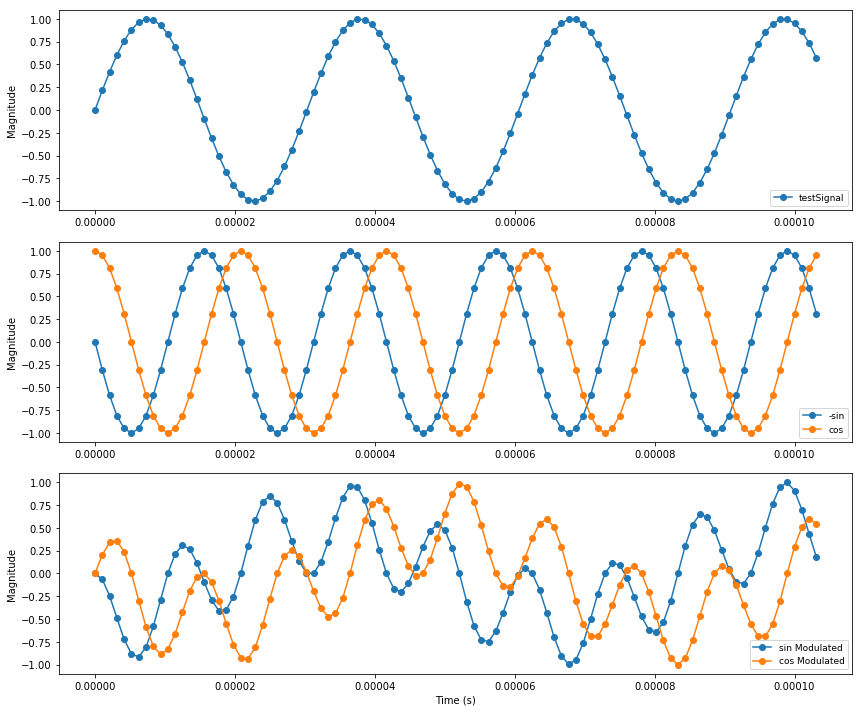

In [5]:
fig = plt.figure()
fig.set_size_inches(12, 10)
index=100
plt.subplot(3, 1, 1)
plt.plot(t[0:index],testSig[0:index], 'o-', label='testSignal')
plt.legend(loc='lower right', prop={'size':9})
plt.ylabel('Magnitude')

plt.subplot(3, 1, 2)
plt.plot(t[0:index],sinCom[0:index], 'o-', label='-sin')
plt.plot(t[0:index],cosCom[0:index], 'o-', label='cos')
plt.ylabel('Magnitude')
plt.legend(loc='lower right', prop={'size':9})

plt.subplot(3, 1, 3)
plt.plot(t[0:index],ch1[0:index], 'o-', label='sin Modulated')
plt.plot(t[0:index],ch2[0:index], 'o-', label='cos Modulated')
plt.ylabel('Magnitude')
plt.xlabel('Time (s)')
plt.legend(loc='lower right', prop={'size':9})

plt.tight_layout()

In [6]:
print("Frequency components=\n")
print(testFreq+deltaFreq)
print(testFreq-deltaFreq)


Frequency components=

81000
-15000


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


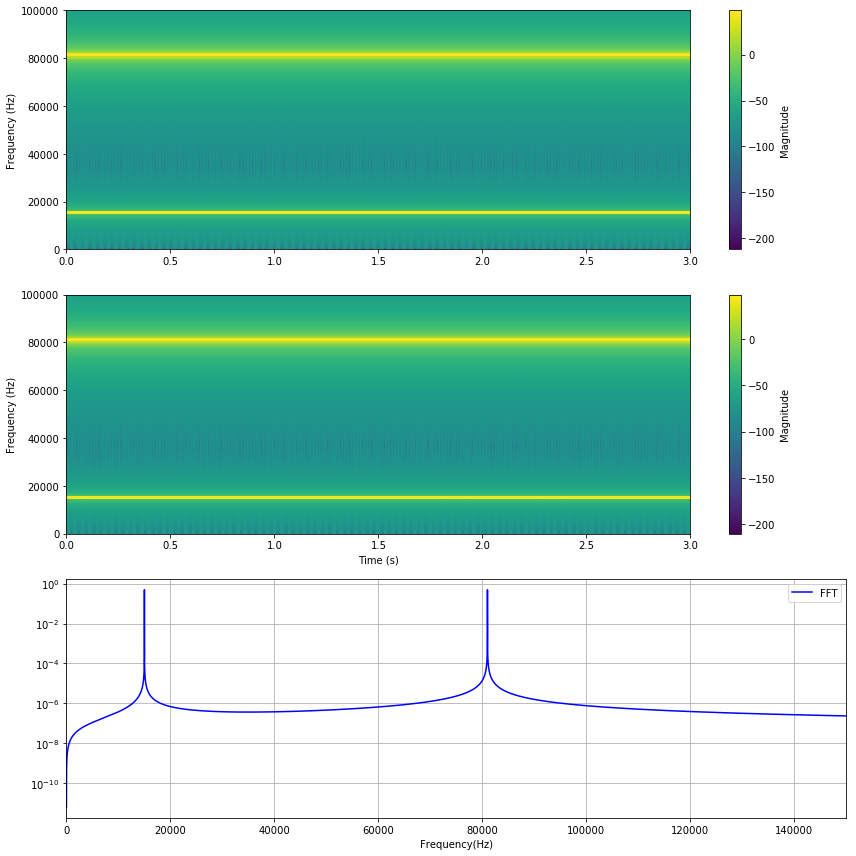

In [7]:
fig = plt.figure()
fig.set_size_inches(12, 12)
ax = fig.add_subplot(111)
ax.set_title('Channel 1 - 33kHz Test Sinusoid Spectrogram')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Frequency(Hz)')
plt.subplot(3, 1, 1)

pxx,  freq, t, cax = plt.specgram(ch1, Fs=FS_acquire,mode='magnitude',NFFT=2048,noverlap=16)
#fig.colorbar(cax).set_label('Power Spectral Density')
fig.colorbar(cax).set_label('Magnitude')
plt.ylabel('Frequency (Hz)')
axes = plt.gca()
axes.set_ylim([0,100000])

plt.subplot(3, 1, 2)
pxx,  freq, t, cax = plt.specgram(ch2, Fs=FS_acquire,mode='magnitude',NFFT=2048,noverlap=16)
fig.colorbar(cax).set_label('Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
axes = plt.gca()
axes.set_ylim([0,100000])

plt.subplot(3, 1, 3)
N = ch2.size
yf = fft(ch2)
xf = np.linspace(0.0, 1.0/(2.0*T_acquire), N/2)
plt.semilogy(xf[1:N/2], 2.0/N * np.abs(yf[1:N/2]), '-b')
plt.legend(['FFT'])
plt.grid()
plt.xlabel('Frequency(Hz)')
axes = plt.gca()
axes.set_xlim([0,150000])

plt.tight_layout()

## Filter Out High Frequency Components

In [8]:
#------------------------------------------------
# Create a FIR filter and apply it to x.
#------------------------------------------------

# The Nyquist rate of the signal.
nyq_rate = FS_acquire / 2.0

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate. 
width = 10000.0/nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 60

# Compute the order and Kaiser parameter for the FIR filter.
N, beta = kaiserord(ripple_db, width)

# The cutoff frequency of the filter.
cutoff_hz = 23800.00

# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))


In [9]:
print("FilterOrder = ",N)
print("kaiser beta = ",beta)

FilterOrder =  350
kaiser beta =  5.65326


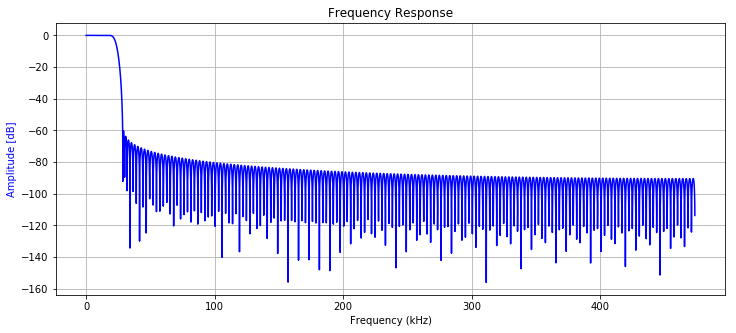

In [10]:
#------------------------------------------------
# Plot the magnitude response of the filter.
#------------------------------------------------

fig = plt.figure()
fig.set_size_inches(12, 5)
plt.clf()
w, h = freqz(taps, worN=8000)
#w, h = freqz(taps)
plt.plot((w*FS_acquire/2*pi)/10000, 20 * np.log10(abs(h)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
xlabel('Frequency (kHz)')
title('Frequency Response')
#ylim(-0.05, 1.05)
#xlim(0, 100000)
grid(True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


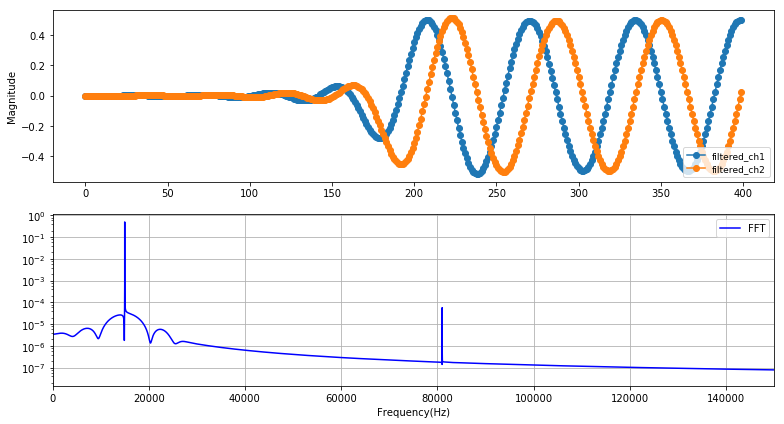

In [11]:
# Use the FIR filter. #filtfilt???
filtered_ch1 = lfilter(taps, 1.0, ch1)
filtered_ch2 = lfilter(taps, 1.0, ch2)

fig = plt.figure()
fig.set_size_inches(11, 6)
index=400
plt.subplot(2, 1, 1)
plt.plot(filtered_ch1[0:index], 'o-', label='filtered_ch1')
plt.plot(filtered_ch2[0:index], 'o-', label='filtered_ch2')
plt.ylabel('Magnitude')
plt.legend(loc='lower right', prop={'size':9})

plt.subplot(2, 1, 2)
N = filtered_ch1.size
yf = fft(filtered_ch1)
xf = np.linspace(0.0, 1.0/(2.0*T_acquire), N/2)
plt.semilogy(xf[1:N/2], 2.0/N * np.abs(yf[1:N/2]), '-b')
plt.legend(['FFT'])
plt.grid()
plt.xlabel('Frequency(Hz)')
axes = plt.gca()
axes.set_xlim([0,150000])

plt.tight_layout()


In [12]:
a = np.arange(1,11,1)
filtered_ch1_downSamp =filtered_ch1[::20]
filtered_ch2_downSamp =filtered_ch2[::20]
print(filtered_ch1[0:21])
print(filtered_ch1_downSamp[0:2])
print(a)
print(a[::3])

[  0.00000000e+00  -2.18647050e-06  -1.06934294e-05  -2.85917646e-05
  -5.69229524e-05  -9.42459655e-05  -1.36822704e-04  -1.79393842e-04
  -2.16336820e-04  -2.42894772e-04  -2.56147574e-04  -2.55468789e-04
  -2.42354956e-04  -2.19687262e-04  -1.90642408e-04  -1.57566237e-04
  -1.21133980e-04  -8.00417773e-05  -3.13272152e-05   2.87576489e-05
   1.03551157e-04]
[ 0.          0.00010355]
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  4  7 10]


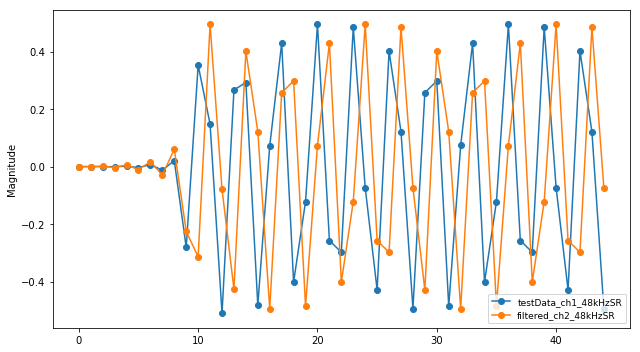

In [13]:
fig = plt.figure()
fig.set_size_inches(9, 5)
index=45

plt.plot(filtered_ch1_downSamp[0:index], 'o-', label='testData_ch1_48kHzSR')
plt.plot(filtered_ch2_downSamp[0:index], 'o-', label='filtered_ch2_48kHzSR')
plt.ylabel('Magnitude')
plt.legend(loc='lower right', prop={'size':9})

plt.tight_layout()

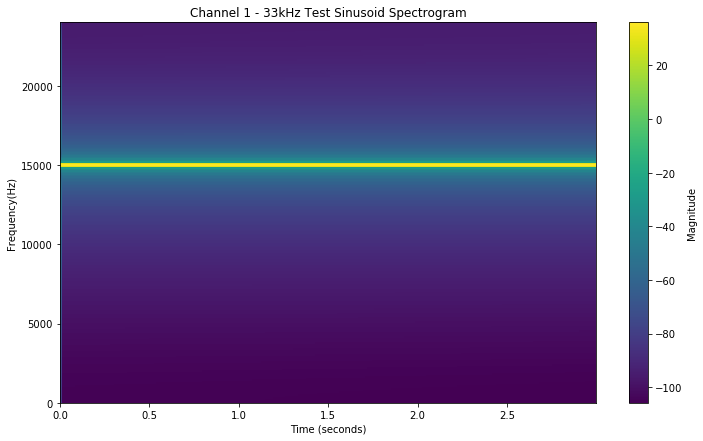

In [14]:
wavFS=48000
fig = plt.figure()
fig.set_size_inches(12, 7)
ax = fig.add_subplot(111)
ax.set_title('Channel 1 - 33kHz Test Sinusoid Spectrogram')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Frequency(Hz)')
pxx,  freq, t, cax = plt.specgram(filtered_ch1_downSamp, Fs=wavFS,mode='magnitude',NFFT=512,noverlap=16)
#fig.colorbar(cax).set_label('Power Spectral Density')
fig.colorbar(cax).set_label('Magnitude')

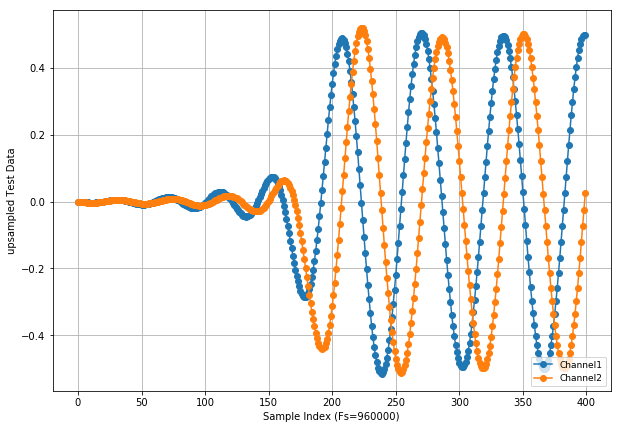

In [15]:

USdata_upsamp_c1 = signal.resample_poly(filtered_ch1_downSamp, FS_acquire, wavFS)
USdata_upsamp_c2 = signal.resample_poly(filtered_ch2_downSamp, FS_acquire, wavFS)

fig = plt.figure()
fig.set_size_inches(10, 7)
plt.plot(USdata_upsamp_c1[0:400], 'o-', label='Channel1')
plt.plot(USdata_upsamp_c2[0:400], 'o-', label='Channel2')
plt.ylabel('upsampled Test Data')
plt.xlabel('Sample Index (Fs=960000)')
plt.legend(loc='lower right', prop={'size':9})
plt.grid(True)

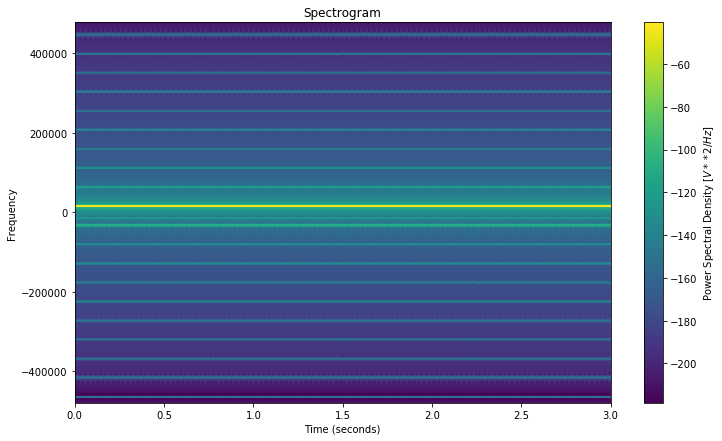

In [16]:
complexUSdataTest = np.add(USdata_upsamp_c1,1j*USdata_upsamp_c2);

fig = plt.figure()
fig.set_size_inches(12, 7)
ax = fig.add_subplot(111)
ax.set_title('Spectrogram')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Frequency')
pxx,  freq, t, cax = plt.specgram((complexUSdataTest).flatten(), Fs=FS_acquire,mode='psd',NFFT=512,noverlap=64)
fig.colorbar(cax).set_label('Power Spectral Density [$V**2/Hz$]')

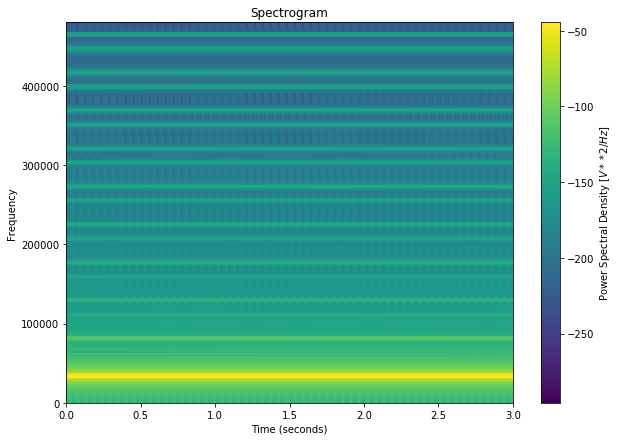

In [17]:
Fs = FS_acquire;                  
T = 1/Fs;  
L = complexUSdataTest.shape[0];
t = np.linspace(0, L*T, L)             
deltaFreq=48000;
#temp=1j*2*pi*deltaFreq*t
comExp = np.exp((1j*2*pi*-1*deltaFreq*t));

demod = comExp*complexUSdataTest

fig = plt.figure()
fig.set_size_inches(10, 7)
ax = fig.add_subplot(111)
ax.set_title('Spectrogram')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Frequency')
pxx,  freq, t, cax = plt.specgram((demod.real).flatten(), Fs=FS_acquire,mode='psd',NFFT=512,noverlap=64)
fig.colorbar(cax).set_label('Power Spectral Density [$V**2/Hz$]')


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


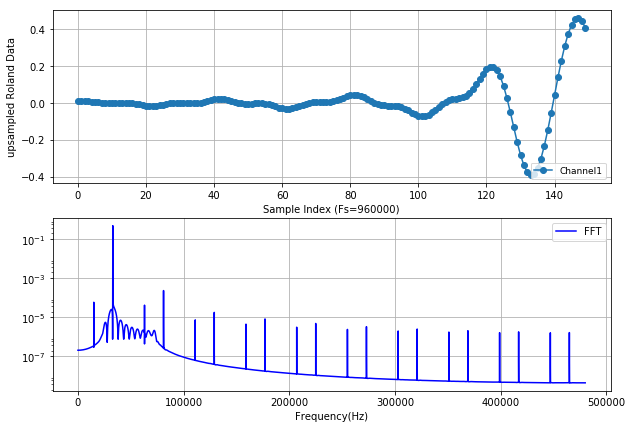

In [18]:
FS_acquire= 960000;

fig = plt.figure()
fig.set_size_inches(10, 7)

plt.subplot(2, 1, 1)
plt.plot(demod.real[50:200], 'o-', label='Channel1')
plt.ylabel('upsampled Roland Data')
plt.xlabel('Sample Index (Fs=960000)')
plt.legend(loc='lower right', prop={'size':9}) 
plt.grid(True)

plt.subplot(2, 1, 2)
N = demod.real.size
T = 1.0 / FS_acquire
y = demod.real
#x = np.linspace(0.0, N*T, N)
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
plt.semilogy(xf[1:N/2], 2.0/N * np.abs(yf[1:N/2]), '-b')
plt.legend(['FFT'])
plt.grid()
plt.xlabel('Frequency(Hz)')

## Hardware Testing

In [19]:
scipy.__version__
wavFS, USdata = wavfile.read('33kHzinput.WAV')
#wavFS, USdata = wavfile.read('H:\0624_043316.WAV')
USdata
#USwaveObject = wave.open('Data/58kHz.WAV', 'rb')
#print("Number of Channels=" , USwaveObject.getnchannels())
#print("Number of Channels=" , USwaveObject.getnframes())
#USwaveObject.close()
wavFS

48000

In [20]:
#fig = plt.figure()
#fig.set_size_inches(12, 7)
#plt.plot(USdata[:,0:1])
#fig = plt.figure()
#fig.set_size_inches(12, 7)
#plt.plot(USdata[:,1:2])

In [21]:
USdata

array([[  8935,   8569],
       [-11961,   5688],
       [   206, -12908],
       ..., 
       [ -7382,  -9985],
       [ 12560,  -3792],
       [ -2213,  12891]], dtype=int16)

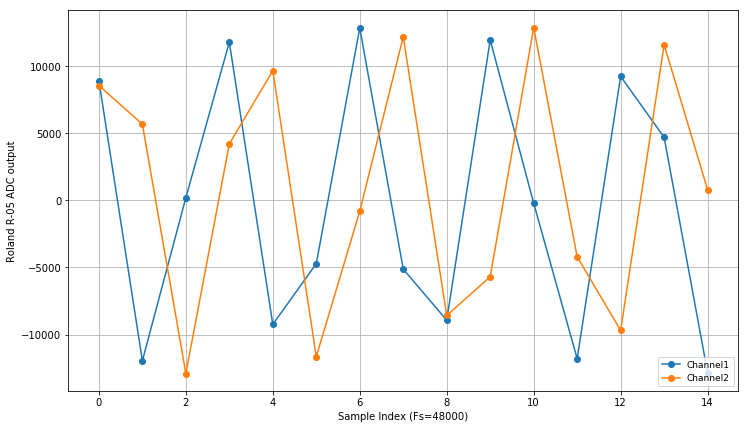

In [22]:
fig = plt.figure()
fig.set_size_inches(12, 7)
plt.plot(USdata[0:15,0:1], 'o-', label='Channel1')
plt.plot(USdata[0:15,1:2], 'o-', label='Channel2')
plt.ylabel('Roland R-05 ADC output')
plt.xlabel('Sample Index (Fs=48000)')
plt.legend(loc='lower right', prop={'size':9})
plt.grid(True)

phase shift?

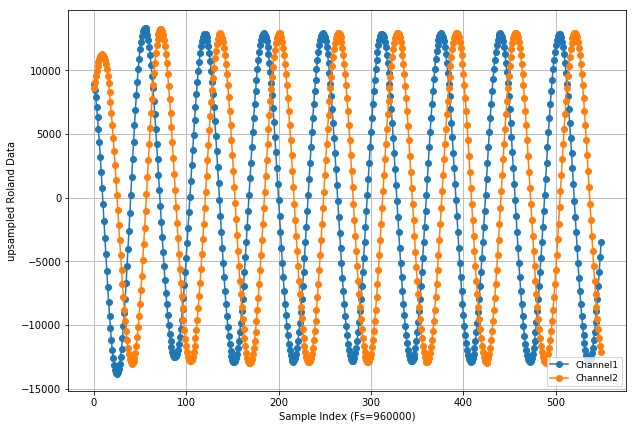

In [23]:
USdata_upsamp = signal.resample_poly(USdata, FS_acquire, wavFS)
fig = plt.figure()
fig.set_size_inches(10, 7)
plt.plot(USdata_upsamp[0:550,0:1], 'o-', label='Channel1')
plt.plot(USdata_upsamp[0:550,1:2], 'o-', label='Channel2')
plt.ylabel('upsampled Roland Data')
plt.xlabel('Sample Index (Fs=960000)')
plt.legend(loc='lower right', prop={'size':9})
plt.grid(True)

In [24]:
USdata_upsamp

array([[ 8941.0186764 ,  8574.77213632],
       [ 8463.0538623 ,  9074.61303194],
       [ 7860.28341152,  9539.87223075],
       ..., 
       [-1255.121824  ,  1867.32218209],
       [ -820.83339214,  1190.11099322],
       [ -399.82210141,   565.93023623]])

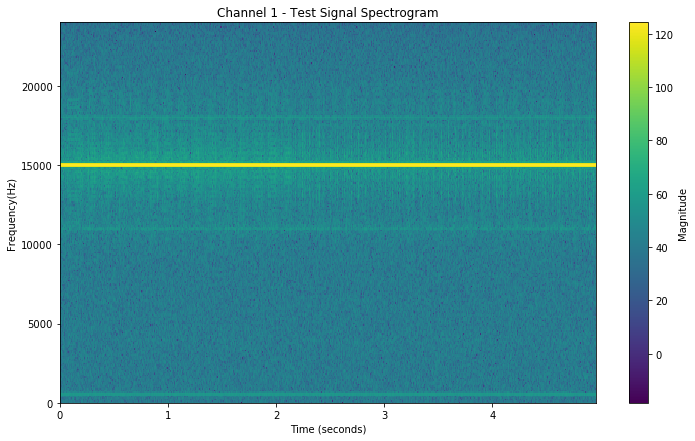

In [25]:
fig = plt.figure()
fig.set_size_inches(12, 7)
ax = fig.add_subplot(111)
ax.set_title('Channel 1 - Test Signal Spectrogram')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Frequency(Hz)')
pxx,  freq, t, cax = plt.specgram(USdata[:,0:1].flatten(), Fs=wavFS,mode='magnitude',NFFT=512,noverlap=64)
#fig.colorbar(cax).set_label('Power Spectral Density')
fig.colorbar(cax).set_label('Magnitude')

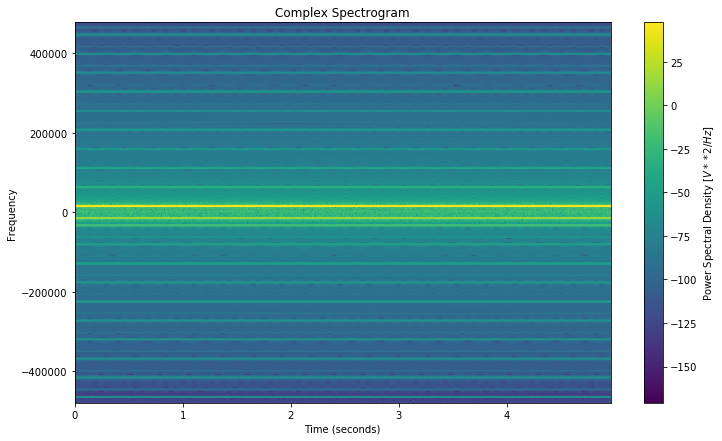

In [26]:
complexUSdata = np.add(USdata_upsamp[:,0:1],1j*USdata_upsamp[:,1:2]);

fig = plt.figure()
fig.set_size_inches(12, 7)
ax = fig.add_subplot(111)
ax.set_title('Complex Spectrogram')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Frequency')
pxx,  freq, t, cax = plt.specgram((complexUSdata).flatten(), Fs=FS_acquire,mode='psd',NFFT=512,noverlap=64)
fig.colorbar(cax).set_label('Power Spectral Density [$V**2/Hz$]')

In [27]:
Fs = FS_acquire;                  
T = 1/Fs;  
L = complexUSdata.shape[0];
t = np.linspace(0, L*T, L)             
deltaFreq=48000;
#temp=1j*2*pi*deltaFreq*t
comExp = np.exp((1j*2*pi*-1*deltaFreq*t));

In [28]:
print(t.size)
print(L)
comExp

4761600
4761600


array([ 1.00000000 +0.00000000e+00j,  0.95105650 -3.09017057e-01j,
        0.80901692 -5.87785359e-01j, ...,  0.80901692 +5.87785359e-01j,
        0.95105650 +3.09017057e-01j,  1.00000000 +1.27434379e-10j])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


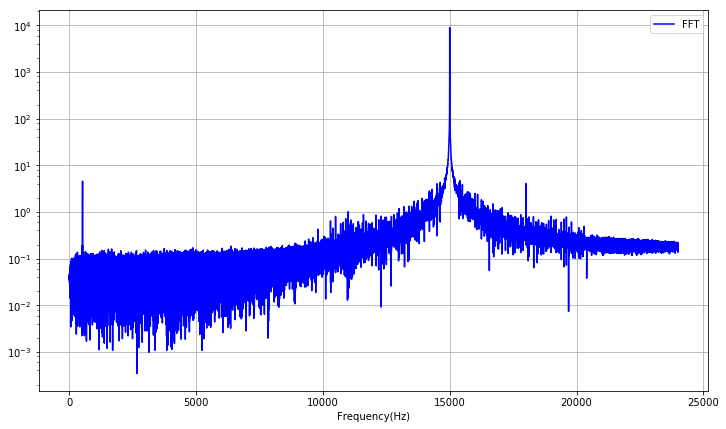

In [29]:
fig = plt.figure()
fig.set_size_inches(12, 7)
N = USdata[:,0:1].size
T = 1.0 / wavFS
y = USdata[:,0:1].flatten()
#x = np.linspace(0.0, N*T, N)
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
plt.semilogy(xf[1:N/2], 2.0/N * np.abs(yf[1:N/2]), '-b')
plt.legend(['FFT'])
plt.grid()
plt.xlabel('Frequency(Hz)')

In [30]:
comExp = comExp.reshape(-1,1)
comExp

array([[ 1.00000000 +0.00000000e+00j],
       [ 0.95105650 -3.09017057e-01j],
       [ 0.80901692 -5.87785359e-01j],
       ..., 
       [ 0.80901692 +5.87785359e-01j],
       [ 0.95105650 +3.09017057e-01j],
       [ 1.00000000 +1.27434379e-10j]])

In [31]:
complexUSdata

array([[ 8941.01867640+8574.77213632j],
       [ 8463.05386230+9074.61303194j],
       [ 7860.28341152+9539.87223075j],
       ..., 
       [-1255.12182400+1867.32218209j],
       [ -820.83339214+1190.11099322j],
       [ -399.82210141 +565.93023623j]])

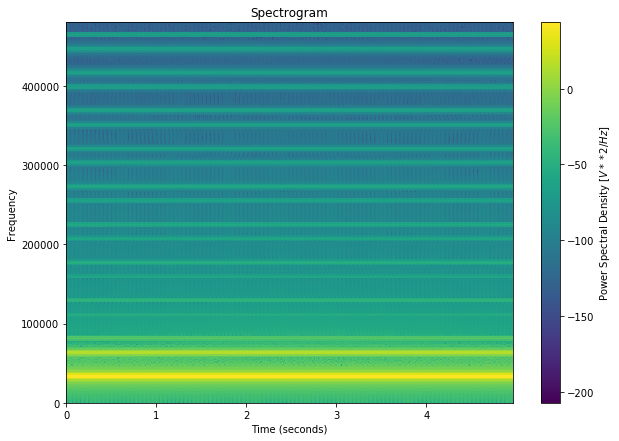

In [32]:
demod = comExp*complexUSdata

fig = plt.figure()
fig.set_size_inches(10, 7)
ax = fig.add_subplot(111)
ax.set_title('Spectrogram')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Frequency')
pxx,  freq, t, cax = plt.specgram((demod.real).flatten(), Fs=FS_acquire,mode='psd',NFFT=512,noverlap=64)
fig.colorbar(cax).set_label('Power Spectral Density [$V**2/Hz$]')

In [33]:
demod.real

array([[  8941.0186764 ],
       [ 10853.05256462],
       [ 11966.49947528],
       ..., 
       [ -2112.9994277 ],
       [ -1148.42352637],
       [  -399.82210148]])

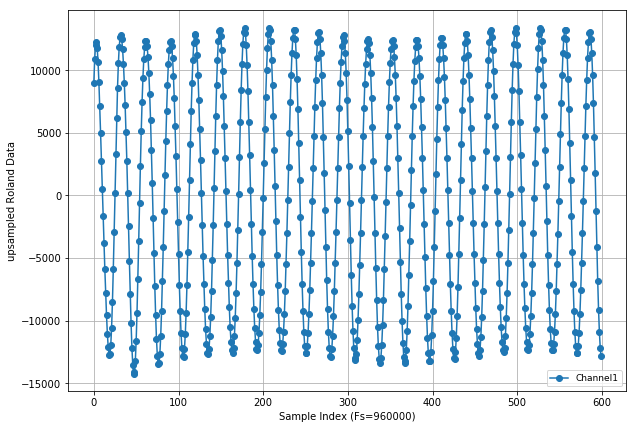

In [34]:
FS_acquire= 960000;

fig = plt.figure()
fig.set_size_inches(10, 7)
plt.plot(demod.real[0:600], 'o-', label='Channel1')
plt.ylabel('upsampled Roland Data')
plt.xlabel('Sample Index (Fs=960000)')
plt.legend(loc='lower right', prop={'size':9})
plt.grid(True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


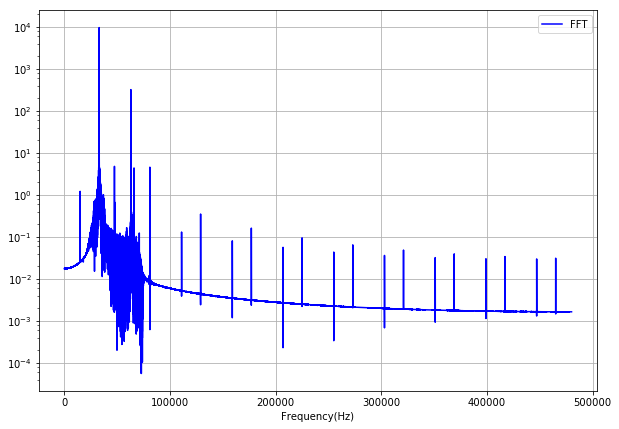

In [35]:
fig = plt.figure()
fig.set_size_inches(10, 7)
N = demod.real[:,0:1].size
T = 1.0 / FS_acquire
y = demod.real[:,0:1].flatten()
#x = np.linspace(0.0, N*T, N)
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
plt.semilogy(xf[1:N/2], 2.0/N * np.abs(yf[1:N/2]), '-b')
plt.legend(['FFT'])
plt.grid()
plt.xlabel('Frequency(Hz)')